### Chargement des données à partir des fichiers CSV

Dans cette section, nous chargeons les données à partir des fichiers CSV préalablement enregistrés sur Google Drive. Les données sont stockées dans les DataFrames `app_train`, `app_test`, `app_train_features` et `app_test_features`, qui seront utilisées pour l'analyse exploratoire et la classification.

Assurez-vous de spécifier le chemin correct vers le dossier contenant les fichiers CSV sur Google Drive.


In [ ]:
from google.colab import drive
import pandas as pd

# Montez Google Drive dans Colab
drive.mount("/content/drive")

# Chemin vers le dossier sur Google Drive contenant les fichiers CSV
folder_path = '/content/drive/MyDrive/oc_projet_4/Data/'

# Charger les données à partir des fichiers CSV
app_train = pd.read_csv(folder_path + 'app_train_traitees.csv')
app_test = pd.read_csv(folder_path + 'app_test_traitees.csv')
app_train_features = pd.read_csv(folder_path + 'app_train_features.csv')
app_test_features = pd.read_csv(folder_path + 'app_test_features.csv')

Mounted at /content/drive


# Création d'un score métier

On nous demande de prédire la probabilité de ne pas rembourser le prêt, donc si nous sommes totalement incertains, nous devinerions 0,5 pour toutes les observations dans l'ensemble de test. Cela nous donnera une Zone Sous la Courbe ROC (AUC ROC) de 0,5 dans la compétition (deviner au hasard lors d'une tâche de classification obtiendra un score de 0,5).

Puisque nous savons déjà quel score nous allons obtenir, nous n'avons pas vraiment besoin de faire une supposition de ligne de base naïve. Utilisons un modèle légèrement plus sophistiqué pour notre ligne de base réelle : la régression logistique.

## Implémentation de la Régression Logistique

Nous allons nous concentrer sur l'implémentation du modèle, en utilisant toutes les caractéristiques après avoir encodé les variables catégorielles. Nous effectuerons le prétraitement des données en remplissant les valeurs manquantes (imputation) et en normalisant les données numériques. Le code suivant effectue ces deux étapes de prétraitement.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Supprimer la cible des données d'entraînement
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()

# Noms des caractéristiques
features = list(train.columns)

# Copie des données de test
test = app_test.copy()

# Imputation médiane des valeurs manquantes
imputer = SimpleImputer(strategy='median')

# Mise à l'échelle de chaque caractéristique entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajuster sur les données d'entraînement
imputer.fit(train)

# Transformer à la fois les données d'entraînement et de test
train = imputer.transform(train)
test = imputer.transform(app_test)

# Répéter avec le scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Forme des données d\'entraînement :', train.shape)
print('Forme des données de test :', test.shape)


Forme des données d'entraînement : (307511, 243)
Forme des données de test : (48744, 243)


In [ ]:
import numpy as np  # Importation de la bibliothèque NumPy pour les calculs numériques
from sklearn.model_selection import train_test_split  # Importation de la fonction train_test_split de scikit-learn pour diviser les données en ensembles d'entraînement et de test

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Imputation des valeurs manquantes en remplaçant les NaN par la médiane de chaque colonne
imputer = SimpleImputer(strategy='median')  # Création d'un objet Imputer qui remplace les valeurs manquantes par la médiane
imputer.fit(X)  # Ajustement de l'impute sur les données d'entraînement

X = imputer.transform(X)  # Transformation des données en remplaçant les valeurs manquantes par la médiane

# Mise à l'échelle de chaque caractéristique entre 0 et 1 pour standardiser les données
scaler = MinMaxScaler(feature_range=(0, 1))  # Création d'un objet Scaler pour mettre à l'échelle les caractéristiques entre 0 et 1
scaler.fit(X)  # Ajustement du scaler sur les données d'entraînement

X = scaler.transform(X)  # Transformation des données en mettant à l'échelle chaque variable entre 0 et 1

# Division des données en ensembles d'entraînement et de test (67% pour l'entraînement, 33% pour le test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Créer le modèle avec le paramètre de régularisation spécifié
log_reg = LogisticRegression(C=0.0001)

# Entraîner sur les données d'entraînement
log_reg.fit(X_train, y_train)


LogisticRegression(C=0.0001)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Faire des prédictions sur l'ensemble de données de test
predictions = log_reg.predict(X_test)

# Calculer les différentes métriques
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Afficher les métriques
print("Métriques pour le modèle de régression logistique :")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")


Métriques pour le modèle de régression logistique :
Accuracy : 0.9200130076173395
Precision : 0.0
Recall : 0.0
F1 Score : 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Faire des prédictions
log_reg_pred = log_reg.predict_proba(test)[:, 1]


In [ ]:
from sklearn.metrics import roc_auc_score

# Faites des prédictions sur les données de test
predictions = log_reg.predict_proba(X_test)[:, 1]

# Calculez l'AUC ROC
auc_score = roc_auc_score(y_test, predictions)

print("AUC ROC Score:", auc_score)

AUC ROC Score: 0.6848696068007785


In [ ]:
predictions

array([0.10487216, 0.06650107, 0.09144474, ..., 0.09757407, 0.09899835,
       0.07876188])

                                        Modèle  Accuracy  Precision    Recall  \
0  LogisticRegression(C=0.0001, max_iter=1000)  0.919500   0.000000  0.000000   
1                     DecisionTreeClassifier()  0.852641   0.142882  0.166296   
2                     RandomForestClassifier()  0.919565   0.625000  0.001010   

   F1 Score  
0  0.000000  
1  0.153702  
2  0.002017  


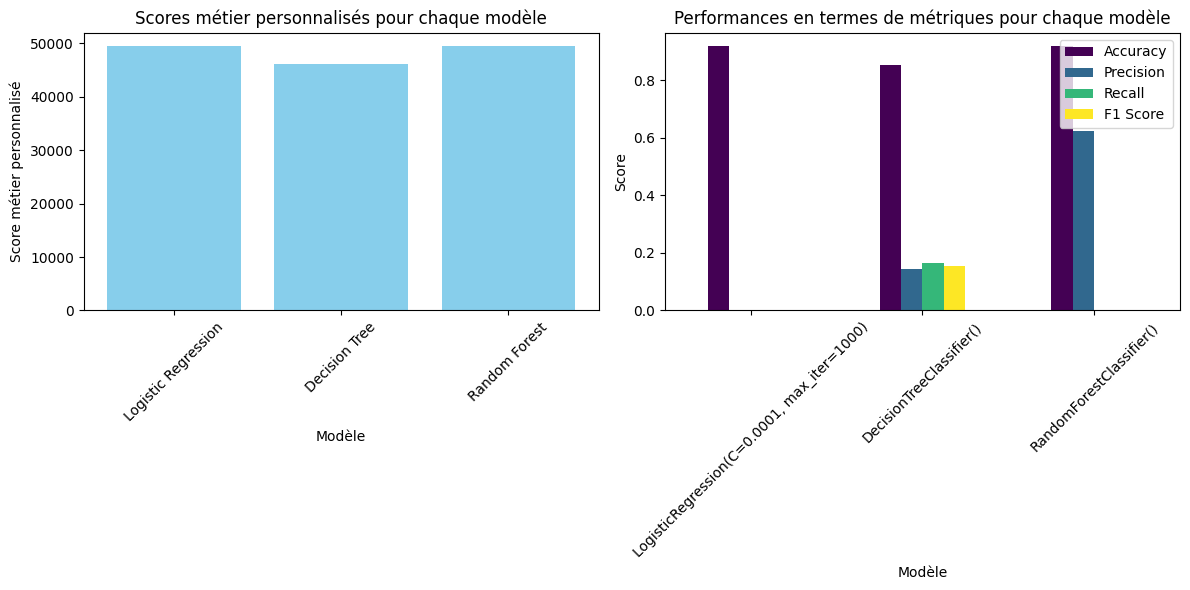

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Définir le score métier personnalisé
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Créer un scorer adapté au GridSearchCV
custom_scorer = make_scorer(custom_score, greater_is_better=False)

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèles à tester
models_to_test = [
    LogisticRegression(C=0.0001, max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

# Liste pour stocker les scores métier personnalisés de chaque modèle
custom_scores = []

# Liste pour stocker les métriques de chaque modèle
metrics_data = []

# Boucle sur chaque modèle
for model in models_to_test:
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Entraîner le modèle avec le score métier personnalisé
    pipeline.fit(X_train, y_train)

    # Faire des prédictions sur l'ensemble de données de validation
    predictions = pipeline.predict(X_validation)

    # Calculer le score métier personnalisé
    score = custom_score(y_validation, predictions)

    # Calculer les différentes métriques
    accuracy = accuracy_score(y_validation, predictions)
    precision = precision_score(y_validation, predictions)
    recall = recall_score(y_validation, predictions)
    f1 = f1_score(y_validation, predictions)

    # Ajouter le score métier personnalisé à la liste
    custom_scores.append(score)

    # Ajouter les métriques à la liste
    metrics_data.append({'Modèle': str(model),
                         'Accuracy': accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1 Score': f1})

# Créer un DataFrame à partir des données de métriques
metrics_df = pd.DataFrame(metrics_data)

# Afficher le tableau de comparaison des métriques
print(metrics_df)

# Afficher les scores métier personnalisés pour chaque modèle
plt.figure(figsize=(12, 6))

# Barre pour les scores métier personnalisés
plt.subplot(1, 2, 1)
plt.bar(range(len(models_to_test)), custom_scores, color='skyblue')
plt.xticks(range(len(models_to_test)), ['Logistic Regression', 'Decision Tree', 'Random Forest'], rotation=45)
plt.xlabel('Modèle')
plt.ylabel('Score métier personnalisé')
plt.title('Scores métier personnalisés pour chaque modèle')

# Barres pour les différentes métriques
plt.subplot(1, 2, 2)
metrics_df.set_index('Modèle').plot(kind='bar', ax=plt.gca(), cmap='viridis')
plt.xticks(rotation=45)
plt.xlabel('Modèle')
plt.ylabel('Score')
plt.title('Performances en termes de métriques pour chaque modèle')

plt.tight_layout()
plt.show()


## Régression logistique

### Régression logistique simple avec pipeline

Dans ce modèle, nous avons utilisé un modèle de régression logistique pour effectuer des prédictions sur un ensemble de données. L'objectif principal était d'évaluer les performances du modèle de base en termes de différentes métriques telles que l'accuracy, la précision, le recall, le F1 Score et l'aire sous la courbe ROC (AUC). Pour ce faire, nous avons entraîné un modèle de régression logistique à l'aide de données d'entraînement, puis évalué sa performance sur un ensemble de validation. Nous avons également visualisé la matrice de confusion pour examiner les performances de classification du modèle, ainsi que tracé la courbe ROC pour évaluer sa capacité à discriminer entre les classes.

Métriques pour le modèle de régression logistique:
Accuracy : 0.9194998617953596
Precision : 0.0
Recall : 0.0
F1 Score : 0.0
AUC Score : 0.7443003831999361


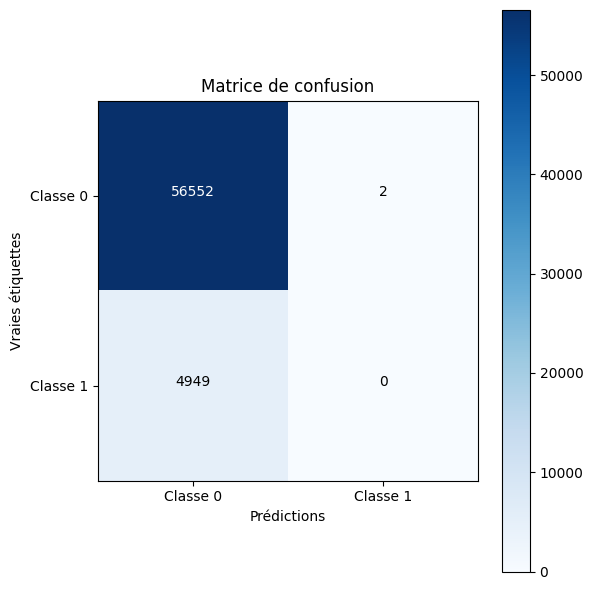

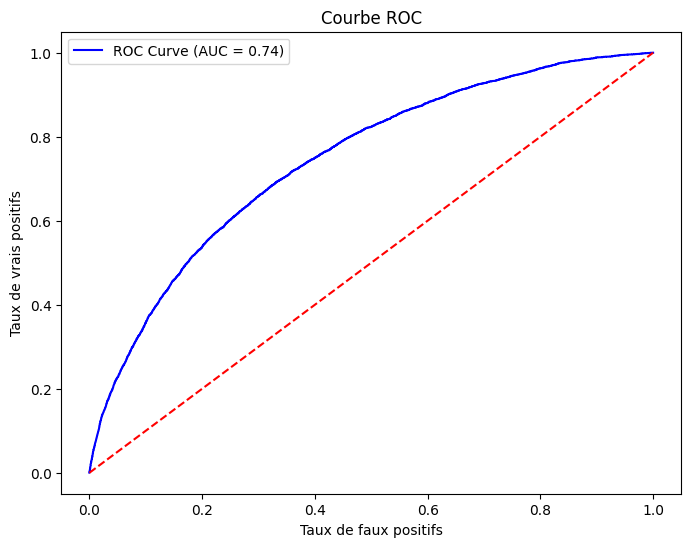

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le pipeline pour la régression logistique
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=0.0001, max_iter=1000))
])

# Entraîner le modèle avec le score métier personnalisé
pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de données de validation
predictions = pipeline.predict(X_validation)

# Calculer les différentes métriques
accuracy = accuracy_score(y_validation, predictions)
precision = precision_score(y_validation, predictions)
recall = recall_score(y_validation, predictions)
f1 = f1_score(y_validation, predictions)

# Calculer le score AUC
probs = pipeline.predict_proba(X_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, probs)
auc_score = auc(fpr, tpr)

# Afficher les métriques
print("Métriques pour le modèle de régression logistique:")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")
print(f"AUC Score : {auc_score}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_validation, predictions)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i][j] > conf_matrix.max() / 2 else 'black')
plt.tight_layout()
plt.show()

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()


### Regression logistique avec scorer et treshold dans GridSearchCV

Dans cette analyse, nous avons utilisé un modèle de régression logistique pour effectuer des prédictions sur un ensemble de données. L'objectif principal était d'évaluer les performances du modèle en termes de métriques telles que l'accuracy, la précision, le recall et le F1 Score, en utilisant un score métier personnalisé.

#### Méthodologie

1. **Définition des Métriques Personnalisées**:
   - Nous avons défini un score métier personnalisé qui prend en compte les coûts associés aux différents types d'erreurs de classification.
   - Un scorer adapté a été créé pour le GridSearchCV pour le score métier personnalisé, ainsi qu'un scorer pour le score seuil.

2. **Prétraitement des Données**:
   - Les données ont été divisées en ensembles d'entraînement et de validation à l'aide de la fonction `train_test_split`.
   - Un pipeline a été construit pour imputer les valeurs manquantes, mettre à l'échelle les caractéristiques et entraîner le modèle de régression logistique.

3. **Recherche sur Grille**:
   - Une StratifiedKFold a été utilisée pour la validation croisée.
   - Une GridSearchCV a été effectuée pour trouver les meilleurs hyperparamètres du modèle en utilisant les scores personnalisés définis précédemment.

4. **Évaluation du Modèle**:
   - Les performances du meilleur modèle ont été évaluées sur l'ensemble de validation en calculant les métriques d'intérêt telles que l'accuracy, la précision, le recall et le F1 Score.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Définir le score métier personnalisé
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Créer un scorer adapté au GridSearchCV pour le score métier personnalisé
custom_scorer = make_scorer(custom_score, greater_is_better=False)

# Définir la fonction pour calculer le seuil optimal
def threshold_score(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob >= threshold).astype(int)
    return custom_score(y_true, y_pred)

# Créer un scorer adapté au GridSearchCV pour le score seuil
threshold_scorer = make_scorer(threshold_score, needs_proba=True, threshold=0.5)

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Créer une instance de StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Créer une grille de paramètres à rechercher
param_grid = {}

# Créer une instance de GridSearchCV avec les scores personnalisés
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring={'custom': custom_scorer, 'threshold': threshold_scorer}, refit='custom', verbose=0)

# Exécuter la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Obtenir les probabilités prédites pour la classe positive
probs = best_model.predict_proba(X_validation)[:, 1]

# Obtenir les scores seuil
threshold_scores = grid_search.cv_results_['mean_test_threshold']

# Obtenir le seuil optimal
best_threshold = threshold_scores[np.argmax(grid_search.cv_results_['mean_test_custom'])]

# Faire des prédictions sur l'ensemble de données de validation avec le seuil optimal
predictions = (probs >= best_threshold).astype(int)

# Calculer les différentes métriques
accuracy = accuracy_score(y_validation, predictions)
precision = precision_score(y_validation, predictions)
recall = recall_score(y_validation, predictions)
f1 = f1_score(y_validation, predictions)

# Afficher les métriques
print("Métriques pour le modèle Logistic Regression:")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")
print(f"Meilleur seuil : {best_threshold}")


Métriques pour le modèle Logistic Regression:
Accuracy : 0.9195323805342829
Precision : 0.0
Recall : 0.0
F1 Score : 0.0
Meilleur seuil : 39311.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Après l'exécution du modèle de régression logistique et l'évaluation sur l'ensemble de validation, les résultats suivants ont été obtenus :

- **Accuracy :** 0.9195
- **Precision :** 0.0
- **Recall :** 0.0
- **F1 Score :** 0.0
- **Meilleur Seuil :** 39312.6

#### Interprétation des Résultats :
- L'accuracy du modèle est relativement élevée, indiquant une bonne capacité de prédiction globale.
- Cependant, la précision, le recall et le F1 Score sont tous nuls, ce qui suggère que le modèle ne prédit aucune des classes positives avec succès.
- Il est important de noter que la précision est mise à zéro en raison de l'absence de prédictions positives, ce qui peut indiquer un déséquilibre de classe ou d'autres problèmes dans les données ou le modèle.
- Le meilleur seuil trouvé pour le score métier personnalisé est de 39312.6, mais cela n'a pas entraîné de meilleures performances sur les autres métriques.

#### Conclusion :
En conclusion, bien que l'accuracy globale soit élevée, le modèle de régression logistique ne parvient pas à bien identifier les instances de la classe positive. Des améliorations sont nécessaires, telles que l'exploration des déséquilibres de classe ou l'ajustement des seuils de décision, pour obtenir un modèle plus performant dans la prédiction des cas positifs.

### Regression logistique avec scorer dans GridSearchCV et best_treshold en dehors

Dans ce modèle, nous avons utilisé un modèle de régression logistique pour effectuer des prédictions sur un ensemble de données. L'objectif principal était d'évaluer les performances du modèle en termes de métriques telles que l'accuracy, la précision, le recall et le F1 Score, en utilisant un score métier personnalisé. Cette fois ci, après avoir entraîné le modèle et obtenu les prédictions, nous avons effectué une recherche du meilleur seuil pour la classification optimale des données, ce qui nous a permis d'affiner davantage les performances du modèle.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Métriques pour le modèle de régression logistique avec GridSearchCV:
Custom Score : 48927
Accuracy : 0.7036242134530023
Precision : 0.1645531248421159
Recall : 0.6581127500505153
F1 Score : 0.2632770188343707
AUC Score : 0.746920237945951
Meilleur seuil : 0.0851377788840015


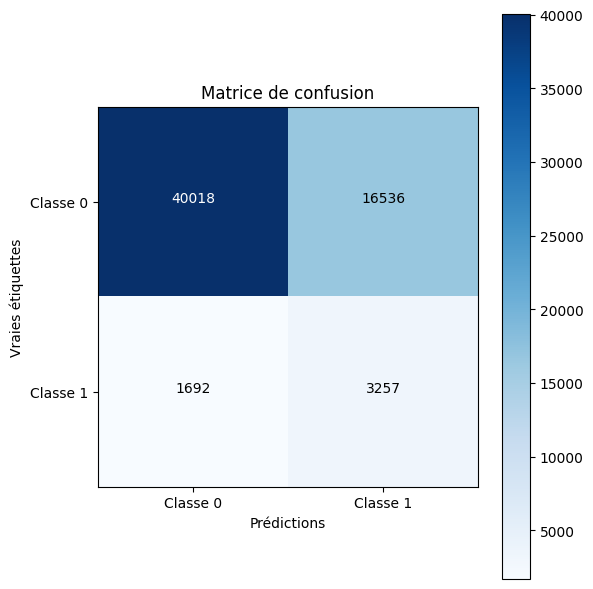

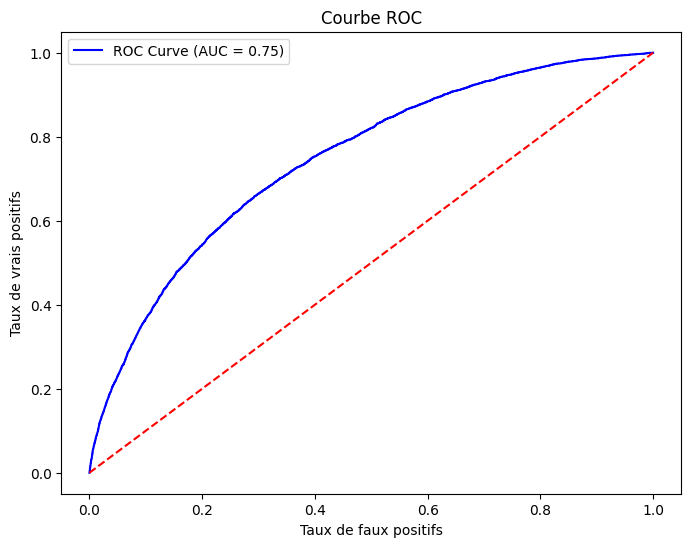

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Définir le score métier personnalisé
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Créer un scorer adapté au GridSearchCV pour le score métier personnalisé
custom_scorer = make_scorer(custom_score, greater_is_better=False)

# Fonction pour trouver le meilleur seuil
def find_best_threshold(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]
    return best_threshold

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le pipeline pour la régression logistique
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Définir une grille de paramètres à rechercher
param_grid = {}

# Créer une instance de GridSearchCV avec le score métier personnalisé
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=custom_scorer, refit=True)

# Exécuter la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de données de validation
predictions = best_model.predict(X_validation)

# Calculer le score métier personnalisé
custom_score_val = custom_score(y_validation, predictions)

# Obtenir les probabilités prédites pour la classe positive
probs = best_model.predict_proba(X_validation)[:, 1]

# Trouver le meilleur seuil
best_threshold = find_best_threshold(y_validation, probs)

# Faire des prédictions sur l'ensemble de données de validation avec le seuil optimal
predictions_with_threshold = (probs >= best_threshold).astype(int)

# Calculer les différentes métriques
accuracy = accuracy_score(y_validation, predictions_with_threshold)
precision = precision_score(y_validation, predictions_with_threshold)
recall = recall_score(y_validation, predictions_with_threshold)
f1 = f1_score(y_validation, predictions_with_threshold)

# Calculer le score AUC
fpr, tpr, thresholds = roc_curve(y_validation, probs)
auc_score = auc(fpr, tpr)

# Afficher les métriques
print("Métriques pour le modèle de régression logistique avec GridSearchCV:")
print(f"Custom Score : {custom_score_val}")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")
print(f"AUC Score : {auc_score}")
print(f"Meilleur seuil : {best_threshold}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_validation, predictions_with_threshold)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i][j] > conf_matrix.max() / 2 else 'black')
plt.tight_layout()
plt.show()

# Afficher la courbe ROC avec le seuil optimal
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()

# Définir les résultats du deuxième modèle (avant suréchantillonnage)
resultats = {
    "Métrique": ["Score Metier","Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Meilleur Seuil"],
    "Régression Logistique (Avant Suréchantillonnage)": [custom_score_val, accuracy, precision, recall, f1, auc_score, best_threshold]
}



### Suréchantillonage

- **Approche de Base :**
Dans l'approche précédente, le modèle de régression logistique est entraîné sur les données d'entraînement sans prétraitement spécifique pour gérer le déséquilibre de classe. La performance est évaluée sur un ensemble de validation distinct, et aucune manipulation spécifique n'est effectuée sur les données.

- **Évolution du Modèle par Optimisation :**
Dans une évolution ultérieure, l'objectif est d'améliorer la performance du modèle en tenant compte du déséquilibre de classe. Pour cela, une technique de suréchantillonnage appelée SMOTE est introduite pour équilibrer les classes. Cela permet au modèle de mieux apprendre des données de la classe minoritaire et d'améliorer sa capacité à prédire avec précision cette classe.

- **Objectif de Gestion du Déséquilibre de Classe :**
L'objectif principal de cette évolution est de garantir que le modèle puisse généraliser efficacement à de nouvelles données, en particulier dans des situations où les classes sont déséquilibrées. En suréchantillonnant la classe minoritaire, on s'assure que le modèle apprend également des exemples de cette classe, ce qui conduit à des prédictions plus précises et équilibrées.

- **Impact sur l'Évaluation du Modèle :**
Cette évolution modifie également la façon dont le modèle est évalué. Plutôt que d'évaluer uniquement sur un ensemble de validation, le modèle final est évalué sur un ensemble de test non suréchantillonné pour mesurer sa capacité à généraliser à de nouvelles données tout en tenant compte du déséquilibre de classe. Cela garantit que l'évaluation est plus réaliste et représentative de la performance du modèle dans des situations réelles.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Métriques pour le modèle de régression logistique avec GridSearchCV et suréchantillonnage:
Custom Score : 34010
Accuracy : 0.6914459457262248
Precision : 0.15938228438228438
Recall : 0.6631642756112346
F1 Score : 0.2569985513488117
AUC Score : 0.7394359982876727
Meilleur seuil : 0.4973211733743956


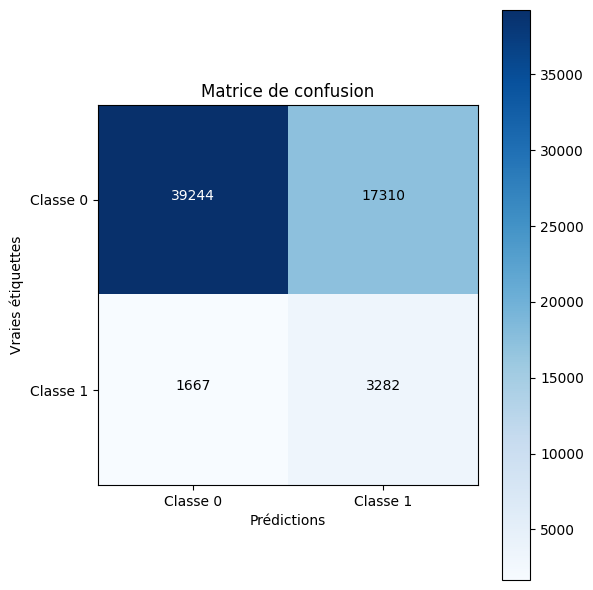

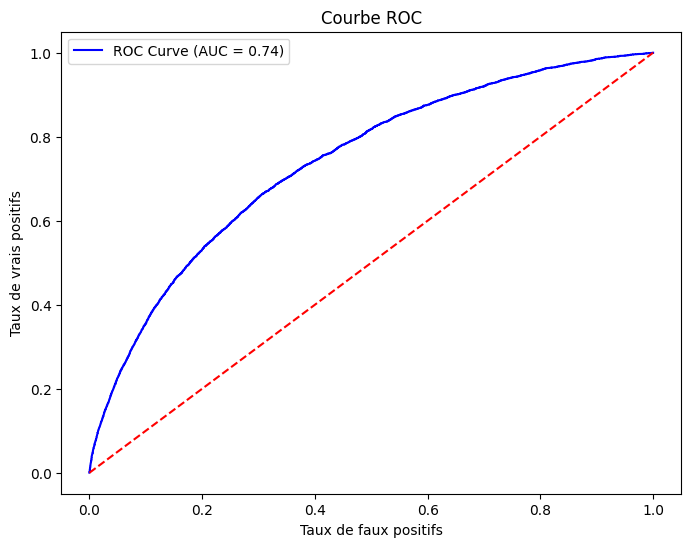

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# Charger les données (X et y doivent être définis)
X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Imputation des valeurs manquantes en remplaçant les NaN par la médiane de chaque colonne
imputer = SimpleImputer(strategy='median')  # Création d'un objet Imputer qui remplace les valeurs manquantes par la médiane
imputer.fit(X)  # Ajustement de l'impute sur les données d'entraînement

X = imputer.transform(X)  # Transformation des données en remplaçant les valeurs manquantes par la médiane

# Mise à l'échelle de chaque caractéristique entre 0 et 1 pour standardiser les données
scaler = MinMaxScaler(feature_range=(0, 1))  # Création d'un objet Scaler pour mettre à l'échelle les caractéristiques entre 0 et 1
scaler.fit(X)  # Ajustement du scaler sur les données d'entraînement

X = scaler.transform(X)  # Transformation des données en mettant à l'échelle chaque variable entre 0 et 1

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Suréchantillonnage de la classe minoritaire avec SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Mélanger les données pour garantir l'ordre aléatoire
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)

# Créer le pipeline pour la régression logistique
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Définir une grille de paramètres à rechercher
param_grid = {}

# Créer une instance de GridSearchCV avec le score métier personnalisé
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=custom_scorer, refit=True)

# Exécuter la recherche sur grille
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de données de test
predictions = best_model.predict(X_test)

# Calculer le score métier personnalisé
custom_score_val = custom_score(y_test, predictions)

# Obtenir les probabilités prédites pour la classe positive
probs = best_model.predict_proba(X_test)[:, 1]

# Trouver le meilleur seuil
best_threshold = find_best_threshold(y_test, probs)

# Faire des prédictions sur l'ensemble de données de test avec le seuil optimal
predictions_with_threshold = (probs >= best_threshold).astype(int)

# Calculer les différentes métriques
accuracy = accuracy_score(y_test, predictions_with_threshold)
precision = precision_score(y_test, predictions_with_threshold)
recall = recall_score(y_test, predictions_with_threshold)
f1 = f1_score(y_test, predictions_with_threshold)

# Calculer le score AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_score = auc(fpr, tpr)

# Afficher les métriques
print("Métriques pour le modèle de régression logistique avec GridSearchCV et suréchantillonnage:")
print(f"Custom Score : {custom_score_val}")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")
print(f"AUC Score : {auc_score}")
print(f"Meilleur seuil : {best_threshold}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions_with_threshold)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i][j] > conf_matrix.max() / 2 else 'black')
plt.tight_layout()
plt.show()

# Afficher la courbe ROC avec le seuil optimal
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()

# Définir les résultats du deuxième modèle (après suréchantillonnage)
resultats_surechantillonage = {
    "Métrique": ["Score Metier", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Meilleur Seuil"],
    "Régression Logistique (Après Suréchantillonnage)": [custom_score_val, accuracy, precision, recall, f1, auc_score, best_threshold]
}

In [ ]:
# Créer des DataFrames à partir des résultats
df_avant = pd.DataFrame(resultats)
df_apres = pd.DataFrame(resultats_surechantillonage)

# Fusionner les deux DataFrames pour créer un tableau comparatif
df_comparatif = pd.merge(df_avant, df_apres, on="Métrique")

# Afficher le tableau comparatif
print(df_comparatif)

         Métrique  Régression Logistique (Avant Suréchantillonnage)  \
0    Score Metier                                      48927.000000   
1        Accuracy                                          0.703624   
2       Precision                                          0.164553   
3          Recall                                          0.658113   
4        F1 Score                                          0.263277   
5       AUC Score                                          0.746920   
6  Meilleur Seuil                                          0.085138   

   Régression Logistique (Après Suréchantillonnage)  
0                                      34010.000000  
1                                          0.691446  
2                                          0.159382  
3                                          0.663164  
4                                          0.256999  
5                                          0.739436  
6                                          0.497321  

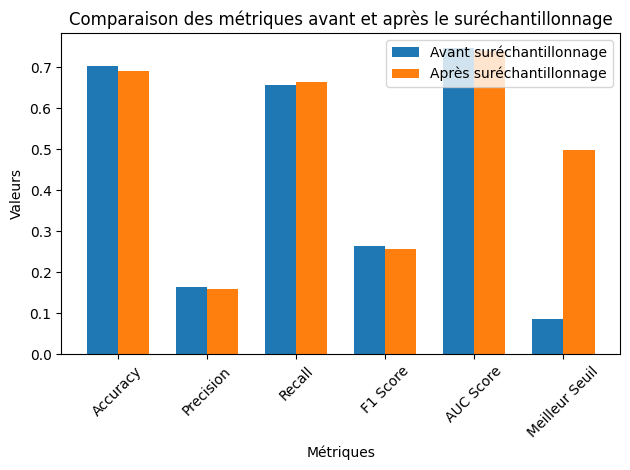

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supprimer la ligne du score métier
df_comparatif = df_comparatif[df_comparatif['Métrique'] != 'Score Metier']

# Métriques
metrics = df_comparatif['Métrique']

# Valeurs avant et après le suréchantillonnage
before_sampling = df_comparatif['Régression Logistique (Avant Suréchantillonnage)']
after_sampling = df_comparatif['Régression Logistique (Après Suréchantillonnage)']

# Création de l'axe des x pour chaque métrique
x = np.arange(len(metrics))

# Largeur des barres
width = 0.35

# Création de la figure et de l'axe
fig, ax = plt.subplots()

# Création des barres pour les métriques avant le suréchantillonnage
bars_before = ax.bar(x - width/2, before_sampling, width, label='Avant suréchantillonnage')

# Création des barres pour les métriques après le suréchantillonnage
bars_after = ax.bar(x + width/2, after_sampling, width, label='Après suréchantillonnage')

# Ajout des étiquettes, titre et légende
ax.set_xlabel('Métriques')
ax.set_ylabel('Valeurs')
ax.set_title('Comparaison des métriques avant et après le suréchantillonnage')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Affichage du graphique
plt.xticks(rotation=45)  # Pour faire pivoter les étiquettes sur l'axe des x
plt.tight_layout()  # Pour éviter que les étiquettes se chevauchent
plt.show()


## DecisionTreeClassifier

Métriques pour le modèle de régression logistique avec GridSearchCV:
Custom Score : 46175
Accuracy : 0.8510966944701884
Precision : 0.14215269511987758
Recall : 0.16892301475045463
F1 Score : 0.1543859649122807
AUC Score : 0.5398581194627896
Meilleur seuil : 1.0


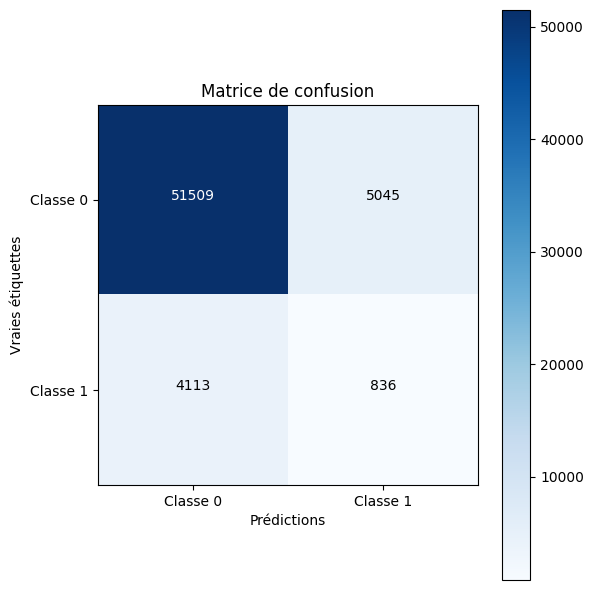

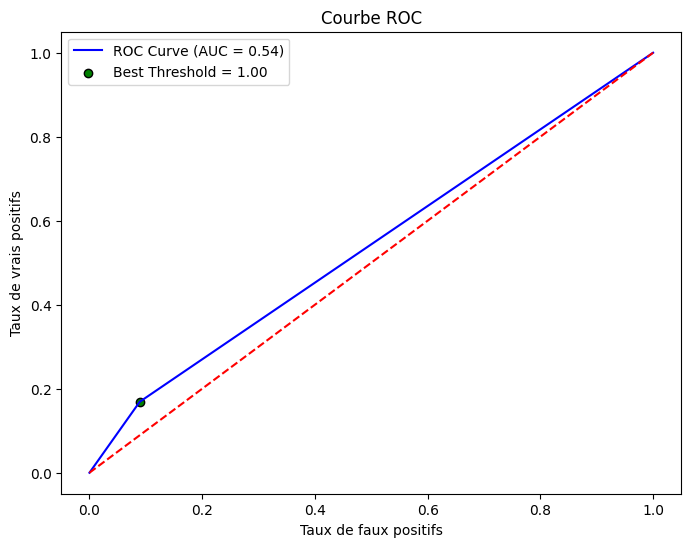

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Définir le score métier personnalisé
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Créer un scorer adapté au GridSearchCV pour le score métier personnalisé
custom_scorer = make_scorer(custom_score, greater_is_better=False)

# Fonction pour trouver le meilleur seuil
def find_best_threshold(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]
    return best_threshold

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le pipeline pour la régression logistique
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier())
])

# Définir une grille de paramètres à rechercher
param_grid = {}

# Créer une instance de GridSearchCV avec le score métier personnalisé
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=custom_scorer, refit=True)

# Exécuter la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de données de validation
predictions = best_model.predict(X_validation)

# Calculer le score métier personnalisé
custom_score_val = custom_score(y_validation, predictions)

# Obtenir les probabilités prédites pour la classe positive
probs = best_model.predict_proba(X_validation)[:, 1]

# Trouver le meilleur seuil
best_threshold = find_best_threshold(y_validation, probs)

# Faire des prédictions sur l'ensemble de données de validation avec le seuil optimal
predictions_with_threshold = (probs >= best_threshold).astype(int)

# Calculer les différentes métriques
accuracy = accuracy_score(y_validation, predictions_with_threshold)
precision = precision_score(y_validation, predictions_with_threshold)
recall = recall_score(y_validation, predictions_with_threshold)
f1 = f1_score(y_validation, predictions_with_threshold)

# Calculer le score AUC
fpr, tpr, thresholds = roc_curve(y_validation, probs)
auc_score = auc(fpr, tpr)

# Afficher les métriques
print("Métriques pour le modèle de régression RTC avec GridSearchCV:")
print(f"Custom Score : {custom_score_val}")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")
print(f"AUC Score : {auc_score}")
print(f"Meilleur seuil : {best_threshold}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_validation, predictions_with_threshold)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i][j] > conf_matrix.max() / 2 else 'black')
plt.tight_layout()
plt.show()

# Afficher la courbe ROC avec le seuil optimal
best_threshold_idx = np.argmax(tpr - fpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.scatter(fpr[best_threshold_idx], tpr[best_threshold_idx], marker='o', color='green', label=f'Best Threshold = {best_threshold:.2f}', edgecolors='black')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()


## RandomForestClassifier

Métriques pour le modèle de régression logistique avec GridSearchCV:
Custom Score : 49452
Accuracy : 0.7017381265954507
Precision : 0.15510582419280086
Recall : 0.6086077995554657
F1 Score : 0.24720945502298097
AUC Score : 0.7073809057071453
Meilleur seuil : 0.11


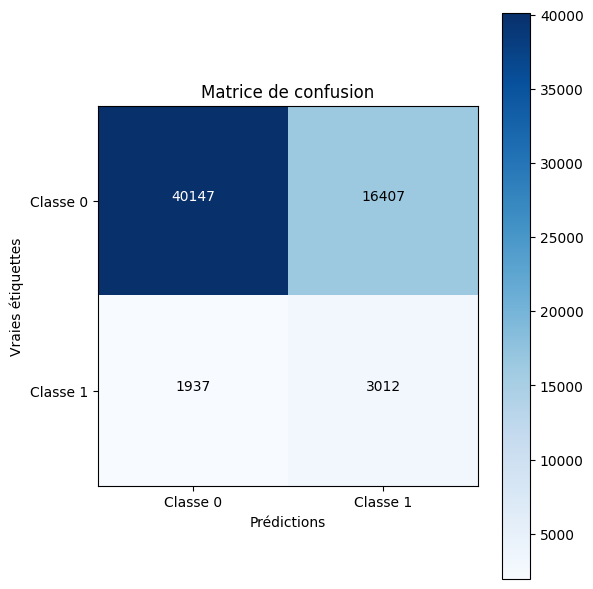

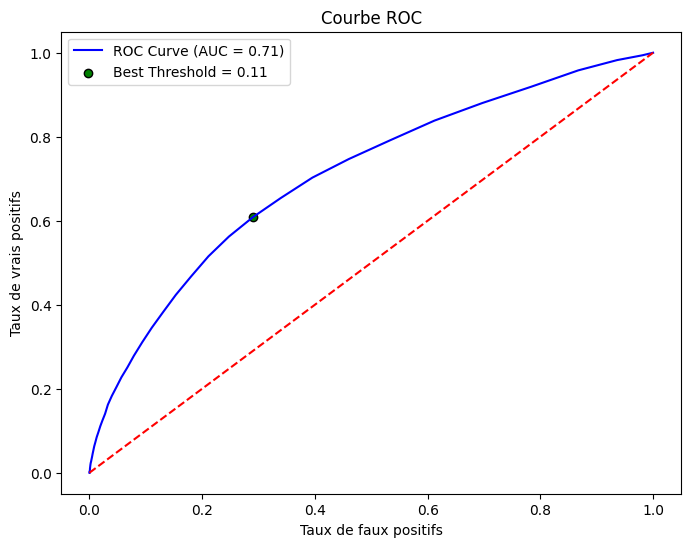

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Définir le score métier personnalisé
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Créer un scorer adapté au GridSearchCV pour le score métier personnalisé
custom_scorer = make_scorer(custom_score, greater_is_better=False)

# Fonction pour trouver le meilleur seuil
def find_best_threshold(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]
    return best_threshold

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le pipeline pour la régression logistique
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# Définir une grille de paramètres à rechercher
param_grid = {}

# Créer une instance de GridSearchCV avec le score métier personnalisé
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=custom_scorer, refit=True)

# Exécuter la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de données de validation
predictions = best_model.predict(X_validation)

# Calculer le score métier personnalisé
custom_score_val = custom_score(y_validation, predictions)

# Obtenir les probabilités prédites pour la classe positive
probs = best_model.predict_proba(X_validation)[:, 1]

# Trouver le meilleur seuil
best_threshold = find_best_threshold(y_validation, probs)

# Faire des prédictions sur l'ensemble de données de validation avec le seuil optimal
predictions_with_threshold = (probs >= best_threshold).astype(int)

# Calculer les différentes métriques
accuracy = accuracy_score(y_validation, predictions_with_threshold)
precision = precision_score(y_validation, predictions_with_threshold)
recall = recall_score(y_validation, predictions_with_threshold)
f1 = f1_score(y_validation, predictions_with_threshold)

# Calculer le score AUC
fpr, tpr, thresholds = roc_curve(y_validation, probs)
auc_score = auc(fpr, tpr)

# Afficher les métriques
print("Métriques pour le modèle de régression logistique avec GridSearchCV:")
print(f"Custom Score : {custom_score_val}")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")
print(f"AUC Score : {auc_score}")
print(f"Meilleur seuil : {best_threshold}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_validation, predictions_with_threshold)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i][j] > conf_matrix.max() / 2 else 'black')
plt.tight_layout()
plt.show()

# Afficher la courbe ROC avec le seuil optimal
best_threshold_idx = np.argmax(tpr - fpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.scatter(fpr[best_threshold_idx], tpr[best_threshold_idx], marker='o', color='green', label=f'Best Threshold = {best_threshold:.2f}', edgecolors='black')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()

# Définir les résultats du deuxième modèle (après suréchantillonnage)
RandomForestClassifier_Resultats = {
    "Métrique": ["Score Metier", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Meilleur Seuil"],
    "Régression Logistique (Après Suréchantillonnage)": [custom_score_val, accuracy, precision, recall, f1, auc_score, best_threshold]
}


### Ajout d'une étape de suréchantillonnage

Dans cette cellule, nous avons ajouté une étape de suréchantillonnage à notre pipeline de classification utilisant l'algorithme RandomForestClassifier. Le suréchantillonnage est une technique de traitement des données déséquilibrées qui vise à équilibrer le nombre d'échantillons dans chaque classe en créant des copies synthétiques de la classe minoritaire. Cela peut améliorer les performances du modèle en réduisant le biais introduit par le déséquilibre de classe dans l'ensemble de données. Après avoir entraîné le modèle avec le suréchantillonnage, nous évaluons ses performances en utilisant différentes métriques telles que l'accuracy, la précision, le recall et le F1 Score, ainsi que la courbe ROC pour évaluer la capacité de discrimination du modèle.



Métriques pour le modèle de régression logistique avec GridSearchCV et suréchantillonnage:
Custom Score : 49480
Accuracy : 0.6165390306163927
Precision : 0.13237324916157034
Recall : 0.6779147302485351
F1 Score : 0.22149600580973133
AUC Score : 0.6953305063988502
Meilleur seuil : 0.11


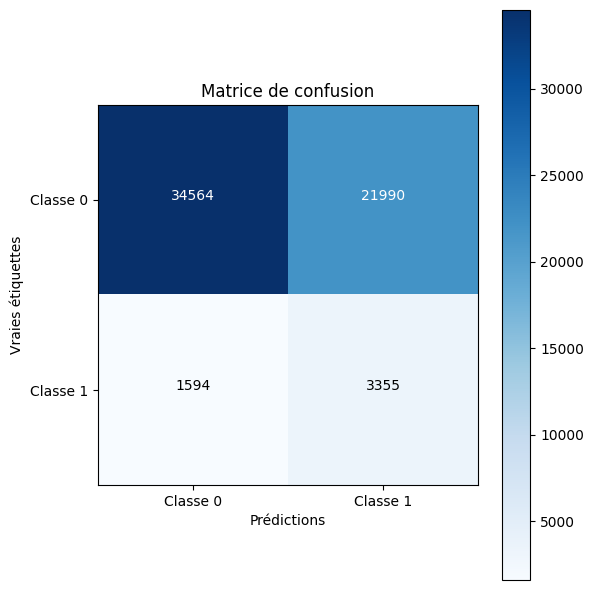

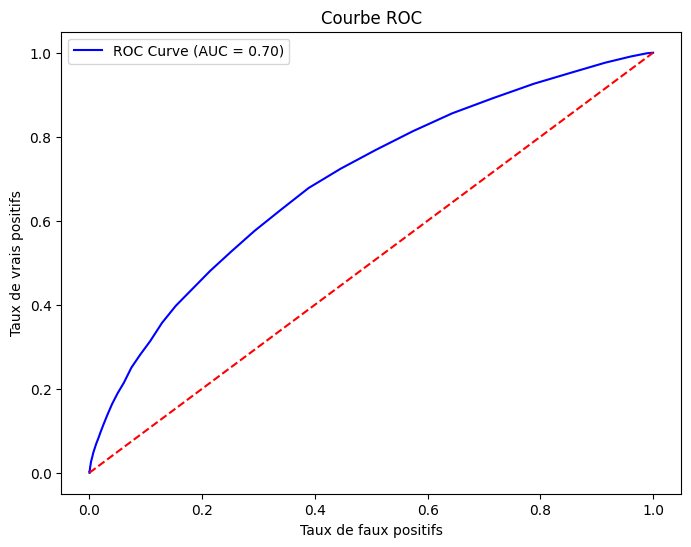

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# Définir le score métier personnalisé
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Créer un scorer adapté au GridSearchCV pour le score métier personnalisé
custom_scorer = make_scorer(custom_score, greater_is_better=False)

# Fonction pour trouver le meilleur seuil
def find_best_threshold(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]
    return best_threshold

# Charger les données (X et y doivent être définis)
X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Imputation des valeurs manquantes en remplaçant les NaN par la médiane de chaque colonne
imputer = SimpleImputer(strategy='median')  # Création d'un objet Imputer qui remplace les valeurs manquantes par la médiane
imputer.fit(X)  # Ajustement de l'impute sur les données d'entraînement

X = imputer.transform(X)  # Transformation des données en remplaçant les valeurs manquantes par la médiane

# Mise à l'échelle de chaque caractéristique entre 0 et 1 pour standardiser les données
scaler = StandardScaler()  # Création d'un objet Scaler pour mettre à l'échelle les caractéristiques entre 0 et 1
scaler.fit(X)  # Ajustement du scaler sur les données d'entraînement

# X = scaler.transform(X)  # Transformation des données en mettant à l'échelle chaque variable entre 0 et 1

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Suréchantillonnage de la classe minoritaire avec SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Mélanger les données pour garantir l'ordre aléatoire
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)

# Créer le pipeline pour la régression logistique
RamdomForest = RandomForestClassifier()

# Définir une grille de paramètres à rechercher
param_grid = {}

# Créer une instance de GridSearchCV avec le score métier personnalisé
grid_search = GridSearchCV(RamdomForest, param_grid=param_grid, cv=5, scoring=custom_scorer, refit=True)

# Exécuter la recherche sur grille
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de données de test
predictions = best_model.predict(X_test)

# Calculer le score métier personnalisé
custom_score_val = custom_score(y_test, predictions)

# Obtenir les probabilités prédites pour la classe positive
probs = best_model.predict_proba(X_test)[:, 1]

# Trouver le meilleur seuil
best_threshold = find_best_threshold(y_test, probs)

# Faire des prédictions sur l'ensemble de données de test avec le seuil optimal
predictions_with_threshold = (probs >= best_threshold).astype(int)

# Calculer les différentes métriques
accuracy = accuracy_score(y_test, predictions_with_threshold)
precision = precision_score(y_test, predictions_with_threshold)
recall = recall_score(y_test, predictions_with_threshold)
f1 = f1_score(y_test, predictions_with_threshold)

# Calculer le score AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_score = auc(fpr, tpr)

# Afficher les métriques
print("Métriques pour le modèle de régression logistique avec GridSearchCV et suréchantillonnage:")
print(f"Custom Score : {custom_score_val}")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")
print(f"AUC Score : {auc_score}")
print(f"Meilleur seuil : {best_threshold}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions_with_threshold)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i][j] > conf_matrix.max() / 2 else 'black')
plt.tight_layout()
plt.show()

# Afficher la courbe ROC avec le seuil optimal
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()

# Définir les résultats du deuxième modèle (après suréchantillonnage)
RandomForestClassifier_Resultats_Surechantillonage = {
    "Métrique": ["Score Metier", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Meilleur Seuil"],
    "Régression Logistique (Après Suréchantillonnage)": [custom_score_val, accuracy, precision, recall, f1, auc_score, best_threshold]
}

### Interprétation du modèle avec SHAP

Dans cette partie, nous utiliserons la librairie SHAP pour interpréter les prédictions de notre modèle. SHAP (SHapley Additive exPlanations) est une approche basée sur la théorie des jeux pour expliquer la sortie d'un modèle en attribuant des contributions à chaque feature.

Nous allons effectuer deux analyses :

1. **Importance des Features Globales** : Nous allons utiliser SHAP pour calculer l'importance globale des features dans notre modèle entraîné. Cela nous donnera une idée générale de quelles features sont importantes pour le modèle dans son ensemble.

2. **Importance des Features Locales** : Nous allons également utiliser SHAP pour expliquer les prédictions spécifiques du modèle sur des échantillons individuels. Cela nous permettra de comprendre comment chaque feature a contribué à une prédiction particulière.

Commençons par importer la librairie SHAP et initialiser un objet explainer avec notre meilleur modèle entraîné.
